In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os
import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image manipulation.
import PIL.Image
from IPython.display import display
#from resizeimage import resizeimage

#Panda
import pandas as pd

#Open a Zip File
from zipfile import ZipFile
from io import BytesIO

#check tensorflow version
tf.__version__

/home/jash/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.7.0'

In [2]:
def DataBase_creator(archivezip, nwigth, nheight, save_name):
    #We choose the archive (zip file) + the new wigth and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    s = (len(archivezip.namelist()[:])-1, nwigth, nheight,3) #nwigth x nheight = number of features because images are nwigth x nheight pixels
    allImage = np.zeros(s)

    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwigth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
    
    #we save the newly created data base
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [3]:
archive_train = ZipFile("/home/jash/Desktop/capstone/train.zip", 'r')

#This line shows the 5 first image name of the train database
archive_train.namelist()[0:5]

#This line shows the number of images in the train database
len(archive_train.namelist()[:])-1 #we must remove the 1st value

10222

In [4]:
image_resize = 40

In [5]:
DataBase_creator(archivezip = archive_train, nwigth = image_resize, nheight = image_resize , save_name = "train")

Time usage: 0:01:16


In [6]:
train = pickle.load( open( "train.p", "rb" ) )
train.shape

(10222, 40, 40, 3)

In [7]:
labels_raw = pd.read_csv("/home/jash/Desktop/capstone/labels.csv.zip", compression='zip', header=0, sep=',', quotechar='"')

#Check 5 random values
labels_raw.sample(5)

,id,breed
3190,4ec829615f7cc33a25c62e8f111db50d,english_setter
2429,3c6a53595e1cd63e63fdc166e4223606,bouvier_des_flandres
4509,708142f49bc6544f2881c6387d91f9c9,lhasa
4674,750b90c9fbb7b7feba76eb5a22956c75,giant_schnauzer
8133,cb64a5454e405b6eef6061fda3433fe5,keeshond


In [8]:
Nber_of_breeds = 120

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 120 main breeds : (10222,)
- The shape of train_filtered dataset is : (10222, 40, 40, 3)


In [9]:
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(10222, 1)

In [10]:
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [11]:
labels_name, labels_bin = matrix_Bin(labels)

Nber SubVariables 120
Shape : (10222, 120)


In [12]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)
X_train.shape

(7155, 40, 40, 3)

In [13]:
df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]

array([ 16,  39,   5,  89,  77, 113,  68,  15,  23])

In [14]:
# Our images are 100 pixels in each dimension.
img_size = image_resize

# Number of colour channels for the images: 3
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Image Shape
img_shape = (img_size, img_size, num_channels)

# Number of classes : 5 breeds
num_classes = Nber_of_breeds

In [15]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
#outputs random value from a truncated normal distribution

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
#outputs the constant value 0.05

In [16]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,
                   use_dropout=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [17]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features


In [18]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 use_dropout=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

In [19]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

In [20]:
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 32         # There are 8 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 64      # There are 16 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 128      # There are 16 of these filters.

# Fully-connected layer.
fc_size = 500 

In [21]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

In [22]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [23]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc1

<tf.Tensor 'dropout_1/mul:0' shape=(?, 500) dtype=float32>

In [24]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 120) dtype=float32>

In [25]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [26]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [27]:
session = tf.Session()

def init_variables():
    session.run(tf.global_variables_initializer())

In [28]:
batch_size = 50

#function next_batch
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [29]:
def optimize(num_iterations, X):
    global total_iterations
    
    start_time = time.time()
    
    #array to plot
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)

            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}
            feed_dict_validation = {x: X_validation,
                               y_true: y_validation,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            # Print status every X iterations.
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
            # Calculate the accuracy on the training-set.
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))
                
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

In [30]:
init_variables()
total_iterations = 0

Iteration:    250, Training Accuracy:   2.0%, Validation Accuracy:   0.8%
Iteration:    500, Training Accuracy:   0.0%, Validation Accuracy:   0.9%
Iteration:    750, Training Accuracy:   2.0%, Validation Accuracy:   0.8%
Iteration:   1000, Training Accuracy:   0.0%, Validation Accuracy:   1.3%
Iteration:   1250, Training Accuracy:   0.0%, Validation Accuracy:   1.9%
Iteration:   1500, Training Accuracy:   0.0%, Validation Accuracy:   2.4%
Iteration:   1750, Training Accuracy:   0.0%, Validation Accuracy:   2.0%
Iteration:   2000, Training Accuracy:   4.0%, Validation Accuracy:   2.2%
Iteration:   2250, Training Accuracy:   2.0%, Validation Accuracy:   2.4%
Iteration:   2500, Training Accuracy:   2.0%, Validation Accuracy:   3.1%
Iteration:   2750, Training Accuracy:   2.0%, Validation Accuracy:   2.9%
Iteration:   3000, Training Accuracy:   0.0%, Validation Accuracy:   3.4%
Time usage: 1:40:24


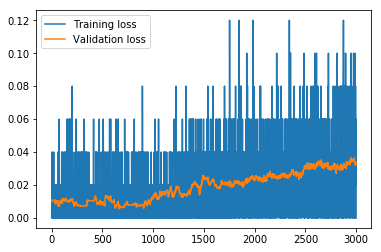

In [ ]:
optimize(num_iterations=3000, X=250)

In [ ]:
optimize(num_iterations=3000, X=50)

Iteration:   3050, Training Accuracy:   4.0%, Validation Accuracy:   3.2%
Iteration:   3100, Training Accuracy:   6.0%, Validation Accuracy:   3.0%
Iteration:   3150, Training Accuracy:   2.0%, Validation Accuracy:   3.4%
Iteration:   3200, Training Accuracy:   6.0%, Validation Accuracy:   3.7%
Iteration:   3250, Training Accuracy:   4.0%, Validation Accuracy:   3.4%
Iteration:   3300, Training Accuracy:   8.0%, Validation Accuracy:   3.3%
Iteration:   3350, Training Accuracy:   2.0%, Validation Accuracy:   3.6%
Iteration:   3400, Training Accuracy:   2.0%, Validation Accuracy:   3.3%
Iteration:   3450, Training Accuracy:   4.0%, Validation Accuracy:   3.3%
Iteration:   3500, Training Accuracy:   2.0%, Validation Accuracy:   3.4%
Iteration:   3550, Training Accuracy:   4.0%, Validation Accuracy:   3.8%
Iteration:   3600, Training Accuracy:   4.0%, Validation Accuracy:   3.8%
Iteration:   3650, Training Accuracy:   4.0%, Validation Accuracy:   3.9%
Iteration:   3700, Training Accuracy: 

In [ ]:
optimize(num_iterations=3000, X=50)

In [ ]:
optimize(num_iterations=3000, X=50)

In [ ]:
optimize(num_iterations=3000, X=50)

In [ ]:
batch_size=100

In [ ]:
optimize(num_iterations=3000, X=50)

In [ ]:
optimize(num_iterations=3000, X=50)